In [2]:
import pandas as pd
import warnings
import numpy as np

warnings.filterwarnings("ignore")


Get Technical Features

In [3]:
sp1500 = pd.read_excel("../data/SPR as of Feb 12 20251.xlsx")
tickers = sp1500['Ticker'].str.split(" ").str[0]


In [4]:
import sys
import os

# Get the absolute path of the project's root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Get the parent directory of the current working directory

# Construct the path to the `src` directory
src_path = os.path.join(project_root, "src")

# Add the `src` directory to the Python module search path
sys.path.append(src_path)


In [5]:
import importlib
from Features import technical_features

importlib.reload(technical_features)
from Features.technical_features import BuildFeatures


In [6]:
# Generate all NYSE trading days from 1980 to 2025
all_dates = pd.bdate_range(start="1980-01-01", end="2024-12-31", freq="B") 
date_to_qid = {date: qid for qid, date in enumerate(all_dates)}


In [7]:
import pickle as pkl
import gzip
from tqdm import tqdm

# Define storage path
cache_path = "../data/technical_features"

# Ensure the directory exists
os.makedirs(cache_path, exist_ok=True)

# Process stock data
for tick in tqdm(tickers, desc="Processing Tickers", unit="ticker"):
    try:
        obj = BuildFeatures(tick)
    except:
        continue
    
    obj.build_technical_features()  # Compute technical indicators
    data = obj.technical_features.copy()
        
    if data.empty:
        continue

    # Convert data to monthly frequency by taking the last value of each month
    data = data.resample('BM').last()

    # Compute returns (convert to float32 to reduce storage size)
    data["Return"] = obj.stock["Close"].pct_change().shift(-1).astype(np.float32)

    # Define file path
    file_path = os.path.join(cache_path, f"{tick}.pkl.gz")

    # Save the data using gzip compression to reduce file size
    with gzip.open(file_path, "wb") as f:
        pkl.dump(data, f, protocol=pkl.HIGHEST_PROTOCOL)

print("✅ All data has been successfully stored and optimized with compression!")


Processing Tickers: 100%|██████████| 1506/1506 [00:00<00:00, 740778.92ticker/s]

✅ All data has been successfully stored and optimized with compression!


In [8]:
# Set cutoff dates for training, validation, and test sets
train_cutoff = "2015-01-01"
valid_cutoff = "2018-01-01"

# Paths
data_path = "../data/technical_features"

# List to store all data
all_data = []

# Process all tickers
for tick in tqdm(tickers, desc="Processing Tickers", unit="ticker"):
    
    file_path = os.path.join(data_path, f"{tick}.pkl.gz")
    try:
        with gzip.open(file_path, "rb") as f:
            data = pkl.load(f)
            data["Ticker"] = tick  # Add ticker label
            all_data.append(data)
    except:
        continue

# **Step 1: Merge all data and sort by date**
all_data = pd.concat(all_data).sort_index()

# Remove rows where 'Return' is NaN
all_data = all_data.dropna(subset=["Return"])

# Drop any remaining NaN values
all_data = all_data.dropna()

# **Step 2: Assign incremental `qid` values based on unique dates**
unique_dates = all_data.index.unique()
date_to_qid = {date: i for i, date in enumerate(unique_dates)}  # Incremental mapping
all_data["qid"] = all_data.index.map(date_to_qid).astype(np.int32)

# **Step 3: Compute quintile ranking for each day's stock returns**
def compute_ranked_labels(df):
    """ Assign quintile ranking to stock returns for each date """
    df["Ranked_Return"] = df.groupby("qid")["Return"].transform(
        lambda x: pd.qcut(x, 5, labels=False, duplicates="drop")  # 0-4 ranking
    ).astype(np.int32)
    return df

all_data = compute_ranked_labels(all_data)

# **Step 4: Split dataset into train, validation, and test sets**
train_data = all_data[all_data.index < train_cutoff]
valid_data = all_data[(all_data.index >= train_cutoff) & (all_data.index < valid_cutoff)]
test_data = all_data[all_data.index >= valid_cutoff]

# **Step 5: Extract features and labels**
def extract_features_labels(df):
    """ Helper function to extract X, y, qid """
    X = df.drop(columns=["Return", "Ranked_Return", "qid", "Ticker"]).values
    y = df["Ranked_Return"].values
    qid = df["qid"].values
    return X, y, qid

X_train, y_train, qid_train = extract_features_labels(train_data)
X_valid, y_valid, qid_valid = extract_features_labels(valid_data)
X_test, y_test, qid_test = extract_features_labels(test_data)

# **Step 5: Save dataset in compressed format**
dataset = {
    "train": (X_train, y_train, qid_train),
    "valid": (X_valid, y_valid, qid_valid),
    "test": (X_test, y_test, qid_test),
}


Processing Tickers: 100%|██████████| 1506/1506 [00:02<00:00, 559.91ticker/s]


In [9]:
all_data

,Close,SMA_50,SMA_200,Chaikin_ADI_Line,Chaikin_ADI_Oscillator,ADM_Index,ADM_Index_Rating,Absolute_Price_Oscillator,Average_True_Range,Average_Price,...,Index_of_lowest_value_over_period,Highest_value_over_period,Index_of_highest_value_over_period,Return,Ticker,MACD,MACD_Signal,MACD_Histogram,qid,Ranked_Return
date,,,,,,,,,,,,,,,,,,,,,
2001-10-31,31.38000000,34.08220000,38.89423750,32612151.75890891,1420404.20974143,30.57978860,27.15310468,-1.70224359,1.12569688,31.37750000,...,206.00000000,33.98000000,195.00000000,0.01242830,ALL,-0.79939017,-0.54746465,-0.25192551,0,2
2001-10-31,13.07000000,15.21680000,24.90195000,12407539.37575923,-2296482.48082595,20.64956842,30.28723921,0.57993590,0.76695614,13.20000000,...,205.00000000,14.50000000,198.00000000,0.03213466,GAP,-0.47151714,-0.56722472,0.09570758,0,3
2001-10-31,42.69450000,44.86882000,45.25154750,17942020.66516422,-595743.80827315,11.90549991,17.06095943,0.92599423,1.52401534,42.56467500,...,205.00000000,45.20330000,200.00000000,0.00187378,BWA,-0.27760165,-0.27817771,0.00057606,0,1
2001-10-31,16.15000000,17.20240000,24.41562500,-5808205.69276940,-104165.05069573,20.75317672,26.91803780,0.92339744,0.80026353,16.32500000,...,206.00000000,17.88000000,202.00000000,0.02662539,CTS,0.01960889,0.01266244,0.00694645,0,3
2001-10-31,27.90000000,28.92340000,31.99154000,30053129.84961401,-839740.69834553,17.71629360,19.89236596,1.58416667,1.88260822,27.58000000,...,196.00000000,30.18000000,203.00000000,-0.03333334,TPR,0.14854014,-0.19987478,0.34841492,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-29,30.09000000,29.12620000,28.09555000,64609900.56039958,1563711.40739463,13.96639609,13.61100472,0.00737179,0.60096344,30.10000000,...,6006.00000000,30.09000000,6015.00000000,0.00631439,GPK,0.16909426,-0.01615515,0.18524940,270,3
2024-11-29,9.94000000,9.47340000,8.53230000,-842974420.94256341,-733962.14024103,25.47933876,32.03703332,0.09705128,0.27696561,9.92875000,...,6008.00000000,10.63000000,6002.00000000,0.04325956,VIAV,0.15252589,0.20399620,-0.05147031,270,4
2024-11-29,322.00000000,300.67040000,276.98610000,114257614.13375528,205428.14571416,34.99119173,35.06073962,5.85006410,5.24300554,321.16000000,...,5897.00000000,322.00000000,5904.00000000,-0.00465839,WTW,5.29779566,5.09207686,0.20571881,270,1


In [10]:
import xgboost as xgb

# Load dataset
(train, valid, test) = (dataset['train'], dataset['valid'], dataset['test'])

# Unpack dataset
X_train, y_train, qid_train = train
X_valid, y_valid, qid_valid = valid
X_test, y_test, qid_test = test

# Initialize XGBoost Ranker with appropriate parameters
ranker = xgb.XGBRanker(
    tree_method="hist",  # Use "gpu_hist" if GPU acceleration is available
    device="cpu",
    lambdarank_pair_method="topk",
    lambdarank_num_pair_per_sample=13,
    eval_metric=["ndcg@1", "ndcg@5"],  
    num_boost_round=1000,
    early_stopping_rounds=50  # Stop training if no improvement for 50 rounds
)

# Train the model
ranker.fit(
    X_train,
    y_train,
    qid=qid_train,
    eval_set=[(X_valid, y_valid)],
    eval_qid=[qid_valid],
    verbose=True,
)

# Retrieve evaluation results
test_eval = ranker.evals_result()
print("✅ Training Completed.")

# Predict on the test set
y_pred = ranker.predict(X_test)

# Create a DataFrame to store predictions
predictions = pd.DataFrame({
    "qid": qid_test,
    "y_true": y_test,
    "y_pred": y_pred
}).sort_values(by="qid")

# Display the first 20 predictions
print(predictions.head(20))


[0]	validation_0-ndcg@1:0.50741	validation_0-ndcg@5:0.46564
[1]	validation_0-ndcg@1:0.37963	validation_0-ndcg@5:0.40616
[2]	validation_0-ndcg@1:0.35556	validation_0-ndcg@5:0.42522
[3]	validation_0-ndcg@1:0.40185	validation_0-ndcg@5:0.44530
[4]	validation_0-ndcg@1:0.38333	validation_0-ndcg@5:0.43841
[5]	validation_0-ndcg@1:0.42222	validation_0-ndcg@5:0.40686
[6]	validation_0-ndcg@1:0.39259	validation_0-ndcg@5:0.41485
[7]	validation_0-ndcg@1:0.47593	validation_0-ndcg@5:0.40559
[8]	validation_0-ndcg@1:0.50926	validation_0-ndcg@5:0.39458
[9]	validation_0-ndcg@1:0.50185	validation_0-ndcg@5:0.41281
[10]	validation_0-ndcg@1:0.51111	validation_0-ndcg@5:0.42627
[11]	validation_0-ndcg@1:0.45185	validation_0-ndcg@5:0.40752
[12]	validation_0-ndcg@1:0.48889	validation_0-ndcg@5:0.44460
[13]	validation_0-ndcg@1:0.52407	validation_0-ndcg@5:0.45227
[14]	validation_0-ndcg@1:0.48333	validation_0-ndcg@5:0.44216
[15]	validation_0-ndcg@1:0.49815	validation_0-ndcg@5:0.45685
[16]	validation_0-ndcg@1:0.53889	v

In [11]:
test_data_selected = test_data.reset_index()[["date", "qid", "Ticker", "Return"]]
predictions['return_true'] = test_data_selected['Return']
predictions["date"] = test_data_selected['date']


In [12]:
predictions

,qid,y_true,y_pred,return_true,date
0,191,0,-0.80847263,-0.01333750,2018-01-31
853,191,0,-0.83539110,-0.01761611,2018-01-31
852,191,0,-0.98269182,-0.02003484,2018-01-31
851,191,3,-0.97917455,0.00815217,2018-01-31
850,191,2,-0.44356477,-0.00418994,2018-01-31
...,...,...,...,...,...
106542,270,0,-0.12139064,-0.02088513,2024-11-29
106541,270,4,-0.78434330,0.05481928,2024-11-29
106540,270,2,-0.66378498,-0.00136240,2024-11-29
106548,270,1,-1.06935954,-0.00909314,2024-11-29


In [13]:
test_data

,Close,SMA_50,SMA_200,Chaikin_ADI_Line,Chaikin_ADI_Oscillator,ADM_Index,ADM_Index_Rating,Absolute_Price_Oscillator,Average_True_Range,Average_Price,...,Index_of_lowest_value_over_period,Highest_value_over_period,Index_of_highest_value_over_period,Return,Ticker,MACD,MACD_Signal,MACD_Histogram,qid,Ranked_Return
date,,,,,,,,,,,,,,,,,,,,,
2018-01-31,95.97000000,90.53380000,74.90540000,961836873.72107875,1029817.28681684,57.00159217,60.86968751,2.02679487,1.77396873,95.35250000,...,4295.00000000,98.95000000,4289.00000000,-0.01333750,VLO,1.74489435,2.28288200,-0.53798765,191,0
2018-01-31,60.71000000,58.33520000,54.72182500,26478733.54288418,-109424.81945059,22.04150535,23.80586163,1.57987179,1.41251550,60.98750000,...,4285.00000000,62.90000000,4288.00000000,0.00658870,FWRD,0.95171241,1.08354020,-0.13182779,191,3
2018-01-31,245.80000000,210.71380000,173.88580000,23414644230.83195877,409379468.30681992,31.13400594,29.65003037,13.73198718,6.36752654,246.32250000,...,4285.00000000,246.85000000,4294.00000000,-0.02156225,NVDA,10.54293071,9.23398282,1.30894789,191,0
2018-01-31,49.31000000,47.22820000,45.50920000,263750817.63661575,186315.67610240,34.49817727,34.25581355,1.17282051,1.40603768,49.53500000,...,4296.00000000,52.82000000,4289.00000000,-0.00162239,JWN,0.84514488,1.21693299,-0.37178810,191,2
2018-01-31,77.98000000,73.36420000,70.16975000,1787647565.28595638,1330893.20421505,41.28428368,29.70078533,2.69519231,0.98470511,77.77750000,...,4283.00000000,78.45000000,4291.00000000,-0.00615542,CTSH,1.52873165,1.38397297,0.14475868,191,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-29,30.09000000,29.12620000,28.09555000,64609900.56039958,1563711.40739463,13.96639609,13.61100472,0.00737179,0.60096344,30.10000000,...,6006.00000000,30.09000000,6015.00000000,0.00631439,GPK,0.16909426,-0.01615515,0.18524940,270,3
2024-11-29,9.94000000,9.47340000,8.53230000,-842974420.94256341,-733962.14024103,25.47933876,32.03703332,0.09705128,0.27696561,9.92875000,...,6008.00000000,10.63000000,6002.00000000,0.04325956,VIAV,0.15252589,0.20399620,-0.05147031,270,4
2024-11-29,322.00000000,300.67040000,276.98610000,114257614.13375528,205428.14571416,34.99119173,35.06073962,5.85006410,5.24300554,321.16000000,...,5897.00000000,322.00000000,5904.00000000,-0.00465839,WTW,5.29779566,5.09207686,0.20571881,270,1


In [14]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam

# -------------------------------
# Define RankNet base model: input features, output a score
# -------------------------------
def build_ranknet_base(input_dim):
    inputs = Input(shape=(input_dim,))
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dense(32, activation='relu')(x)
    score = layers.Dense(1, activation=None)(x)
    return Model(inputs=inputs, outputs=score)

# -------------------------------
# Construct Pairwise data
# For each query (qid), construct sample pairs (i, j) within the same date, 
# ensuring y_i != y_j, and the left sample label is greater than the right sample label
# -------------------------------
import random

def generate_pairs(X, y, qid, max_pairs_per_query=1000):
    """
    Construct sample pairs within each qid, and randomly sample max_pairs_per_query pairs if too many pairs exist
    """
    pairs_left = []
    pairs_right = []
    unique_qids = np.unique(qid)
    for q in unique_qids:
        idx = np.where(qid == q)[0]
        if len(idx) < 2:
            continue
        X_q = X[idx]
        y_q = y[idx]
        candidate_pairs = []
        for i in range(len(idx)):
            for j in range(i+1, len(idx)):
                # Skip if labels are the same
                if y_q[i] == y_q[j]:
                    continue
                # Ensure the left sample label is higher
                if y_q[i] > y_q[j]:
                    candidate_pairs.append((X_q[i], X_q[j]))
                else:
                    candidate_pairs.append((X_q[j], X_q[i]))
        # Randomly sample max_pairs_per_query pairs if too many pairs exist
        if len(candidate_pairs) > max_pairs_per_query:
            candidate_pairs = random.sample(candidate_pairs, max_pairs_per_query)
        # Add to global list
        for left, right in candidate_pairs:
            pairs_left.append(left)
            pairs_right.append(right)
    return np.array(pairs_left, dtype=np.float32), np.array(pairs_right, dtype=np.float32)


In [15]:
# -------------------------------
# Get input dimension
# -------------------------------
input_dim = X_train.shape[1]

# Generate training data pairs
pairs_left, pairs_right = generate_pairs(X_train, y_train, qid_train)
# For each pair, since we have ensured that the left sample label is higher than the right sample,
# all pair labels are 1 (indicating the left should rank higher than the right)
pair_labels = np.ones(len(pairs_left))

print("Generated {} pairs for RankNet training".format(len(pairs_left)))

# -------------------------------
# Build RankNet model
# Use the shared base model to score the left and right samples separately
# -------------------------------
input_left = Input(shape=(input_dim,))
input_right = Input(shape=(input_dim,))

# Build shared base model
base_model = build_ranknet_base(input_dim)

score_left = base_model(input_left)
score_right = base_model(input_right)

# Calculate the score difference and get the probability through sigmoid
prob = layers.Activation('sigmoid')(score_left - score_right)

# Construct the final RankNet model, input is a pair of samples, output is the probability
ranknet_model = Model(inputs=[input_left, input_right], outputs=prob)
ranknet_model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy')

ranknet_model.summary()


Generated 155000 pairs for RankNet training


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 121)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 121)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 1)         │      9,921 │ input_layer[0][0… │
│ (Functional)        │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 1)         │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ subtract[0][0]    │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,921 (38.75 KB)

 Trainable params: 9,921 (38.75 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# -------------------------------
# Train RankNet model
# -------------------------------
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

ranknet_history = ranknet_model.fit(
    [pairs_left, pairs_right],
    pair_labels,
    epochs=10,           
    batch_size=256,
    validation_split=0.1,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 510953.1250 - val_loss: 281108.0625
Epoch 2/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step - loss: 337389.9375 - val_loss: 500136.8750
Epoch 3/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 936us/step - loss: 287480.4688 - val_loss: 235488.4844
Epoch 4/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 943us/step - loss: 227611.8594 - val_loss: 131816.7969
Epoch 5/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 963us/step - loss: 137380.7500 - val_loss: 80388.9531
Epoch 6/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 978us/step - loss: 111587.9922 - val_loss: 236277.7969
Epoch 7/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 959us/step - loss: 83117.4844 - val_loss: 58186.1406
Epoch 8/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 951us/step - loss: 63503.3828 - val_loss: 85833.2656
Epoch 9/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 969us/step - loss: 58072.2188 - val_loss: 33910.0273
Epoch 10/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 32740.0254 - val_loss: 38870.3047


In [23]:
# -------------------------------
# Predict on the test set: Use the trained base model to score each sample
# -------------------------------
X_test = X_test.astype(np.float32)
y_pred_ranknet = base_model.predict(X_test).flatten()

# Combine RankNet predictions with qid and true labels into a DataFrame
predictions_ranknet = pd.DataFrame({
    "qid": qid_test,
    "y_true": y_test,
    "y_pred_ranknet": y_pred_ranknet
}).sort_values(by="qid")

print("RankNet predictions:")
print(predictions_ranknet.head(50))

3359/3359 ━━━━━━━━━━━━━━━━━━━━ 1s 382us/step
RankNet predictions:
     qid  y_true   y_pred_ranknet
0    191       0  -47162.75000000
853  191       0    5749.27343750
852  191       0   -6129.78125000
851  191       3   -4055.50781250
850  191       2    -417.68750000
849  191       3   -6459.25000000
848  191       1    -210.48535156
847  191       4   34125.18750000
846  191       2   -1153.69531250
845  191       1    -967.60156250
844  191       4  -22091.67187500
843  191       4     422.57421875
842  191       2    -118.68750000
841  191       1  -37076.37500000
840  191       4     612.41015625
839  191       1  -17691.87500000
854  191       4   -2863.08593750
855  191       3    -277.39257812
856  191       0   -3119.90625000
857  191       1    -217.49218750
873  191       0    6849.93750000
872  191       3    -545.10156250
871  191       2   65054.25000000
870  191       2      84.73632812
869  191       3     897.63281250
868  191       0   -8853.67187500
867  191       1

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def backtest_strategy(predictions, top_k=50, position_size=None, risk_free_rate=0.00):
  """
  General backtesting function:
  The input predictions DataFrame must contain the following columns:
    - "qid": Query ID for each sample
    - "y_pred": Model predicted score (LTR score)
    - "return_true": Actual return
    - "date": Trading date (preferably end of month)
  Output:
    - Backtested DataFrame (including calculated signals and strategy returns)
    - Cumulative P&L time series (LTR strategy)
    - Cumulative P&L time series (random strategy)
    - Strategy performance metrics dictionary
    - Random strategy performance metrics dictionary
  """
  # If position size is not specified, set it to 1/(top_k*2)
  if position_size is None:
    position_size = 1 / (top_k * 2)
    
  df = predictions.copy()
  df = df.sort_values(by="qid")
  
  # LTR strategy: Sort by predicted score, select top_k as long positions, bottom top_k as short positions
  df["rank"] = df.groupby("qid")["y_pred"].rank(ascending=False, method="first")
  df["long"] = (df["rank"] <= top_k).astype(int)
  df["short"] = (df["rank"] > (df.groupby("qid")["rank"].transform("max") - top_k)).astype(int)
  
  df["long_return"] = df["long"] * df["return_true"]
  df["short_return"] = -df["short"] * df["return_true"]  # Short returns are negative
  df["ltr_strategy_return"] = position_size * (df["long_return"] + df["short_return"])
  
  # Random strategy (benchmark): Randomly select top_k long and short positions within each qid
  df["random_long"] = df.groupby("qid")["y_pred"].transform(
    lambda x: np.random.choice([1, 0], size=len(x), p=[top_k / len(x), 1 - top_k / len(x)])
  )
  df["random_short"] = df.groupby("qid")["y_pred"].transform(
    lambda x: np.random.choice([1, 0], size=len(x), p=[top_k / len(x), 1 - top_k / len(x)])
  )
  df["random_long_return"] = df["random_long"] * df["return_true"]
  df["random_short_return"] = -df["random_short"] * df["return_true"]
  df["random_strategy_return"] = position_size * (df["random_long_return"] + df["random_short_return"])
  
  # Aggregate monthly returns by date (note: the date column should be in date format or string)
  monthly_pnl = df.groupby("date")["ltr_strategy_return"].sum()
  monthly_pnl_random = df.groupby("date")["random_strategy_return"].sum()
  
  cumulative_pnl = monthly_pnl.cumsum()
  cumulative_pnl_random = monthly_pnl_random.cumsum()
  
  # Define performance metrics calculation function
  def compute_metrics(monthly_pnl, label):
    mean_return = monthly_pnl.mean() * 12  # Annualized return
    std_dev = monthly_pnl.std() * np.sqrt(12)  # Annualized volatility
    sharpe = (mean_return - risk_free_rate) / std_dev if std_dev != 0 else np.nan
    return {"Strategy": label, "Annualized Return": mean_return,
      "Annualized Volatility": std_dev, "Sharpe Ratio": sharpe}
  
  metrics = compute_metrics(monthly_pnl, "LTR Strategy")
  random_metrics = compute_metrics(monthly_pnl_random, "Random Strategy")
  
  return df, cumulative_pnl, cumulative_pnl_random, metrics, random_metrics


Performance metrics comparison:
       Strategy  Annualized Return  Annualized Volatility  Sharpe Ratio
0  LTR Strategy         0.04538821             0.04071771    1.11470415
1  LTR Strategy         0.01462899             0.02966774    0.49309404


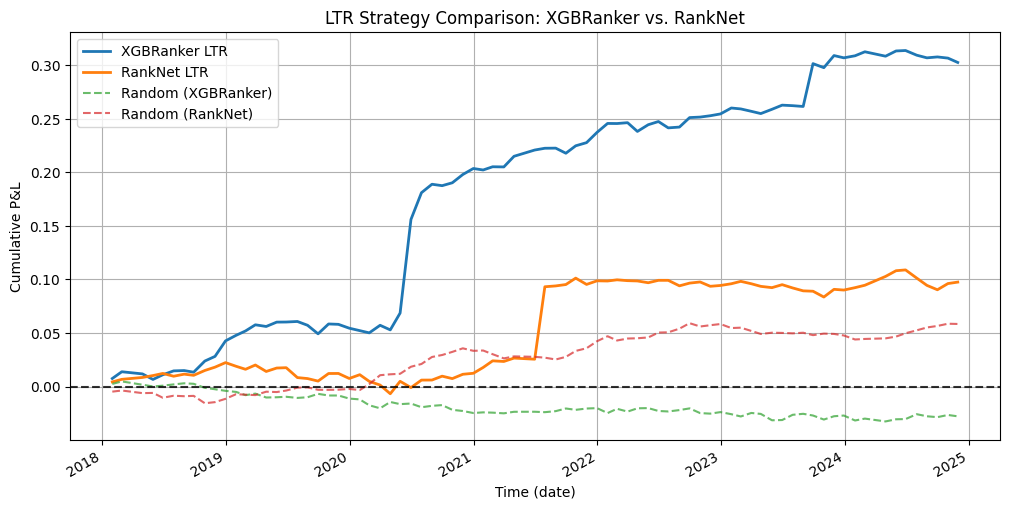

In [24]:
# ============================
# Assume you have obtained the prediction results of two LTR methods
# ----------------------------
# XGBRanker (LambdaRank) prediction results
# The predictions_xgb DataFrame contains: "qid", "y_true", "y_pred", "return_true", "date"
predictions_xgb = pd.DataFrame({
    "qid": qid_test,
    "y_true": y_test,
    "y_pred": y_pred  # XGBRanker predicted scores
}).sort_values(by="qid")
test_data_selected = test_data.reset_index()[["date", "qid", "Ticker", "Return"]]
predictions_xgb["return_true"] = test_data_selected["Return"]
predictions_xgb["date"] = test_data_selected["date"]

# RankNet prediction results
# The predictions_ranknet DataFrame originally contains "y_pred_ranknet", rename it to "y_pred"
predictions_ranknet = pd.DataFrame({
    "qid": qid_test,
    "y_true": y_test,
    "y_pred_ranknet": y_pred_ranknet  # RankNet predicted scores
}).sort_values(by="qid")
# Add return and date information
predictions_ranknet["return_true"] = test_data_selected["Return"]
predictions_ranknet["date"] = test_data_selected["date"]
predictions_ranknet.rename(columns={"y_pred_ranknet": "y_pred"}, inplace=True)

# ============================
# Backtest the two LTR methods separately
# ----------------------------
df_xgb, cum_xgb, cum_random_xgb, metrics_xgb, random_metrics_xgb = backtest_strategy(predictions_xgb)
df_ranknet, cum_ranknet, cum_random_ranknet, metrics_ranknet, random_metrics_ranknet = backtest_strategy(predictions_ranknet)

# Summarize performance metrics
metrics_df = pd.DataFrame([metrics_xgb, metrics_ranknet])
print("Performance metrics comparison:")
print(metrics_df)

# ============================
# Plot cumulative P&L comparison
# ----------------------------
plt.figure(figsize=(12, 6))
cum_xgb.plot(label="XGBRanker LTR", linewidth=2)
cum_ranknet.plot(label="RankNet LTR", linewidth=2)
# Optional: Plot cumulative P&L for random strategy (note that the random part will vary slightly each time)
cum_random_xgb.plot(label="Random (XGBRanker)", linestyle="dashed", alpha=0.7)
cum_random_ranknet.plot(label="Random (RankNet)", linestyle="dashed", alpha=0.7)
plt.axhline(y=0, color="black", linestyle="--", alpha=0.8)
plt.xlabel("Time (date)")
plt.ylabel("Cumulative P&L")
plt.title("LTR Strategy Comparison: XGBRanker vs. RankNet")
plt.legend()
plt.grid()
plt.show()


6281/6281 ━━━━━━━━━━━━━━━━━━━━ 2s 362us/step

K-fold CV on (train+valid), best alpha = 0.90, corresponding average Sharpe = 0.1044

ENS ML (Final) on Test Set
       Strategy  Annualized Return  Annualized Volatility  Sharpe Ratio
0  LTR Strategy         0.04857814             0.03977323    1.22137781


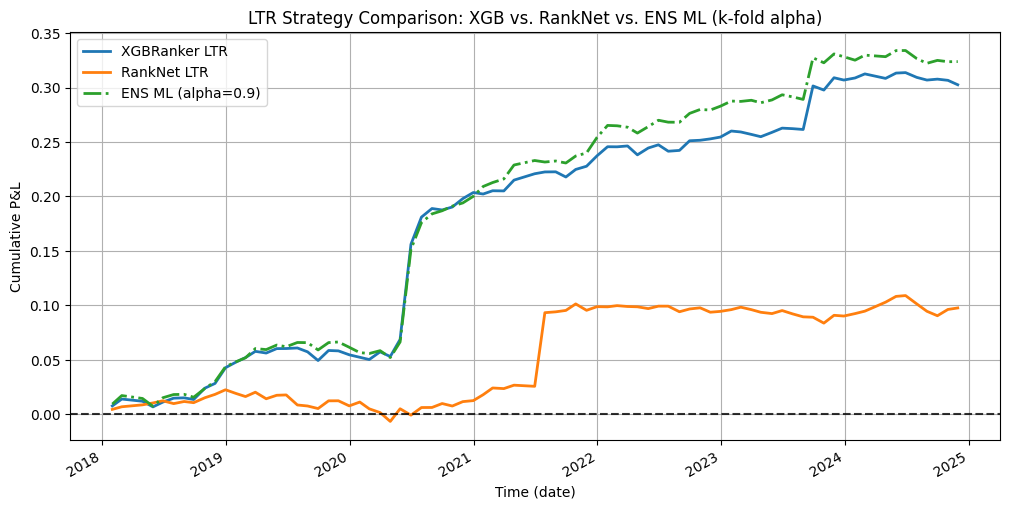

In [29]:
# (A) Combine train_data + valid_data and get prediction scores
# 1) Combine
trainVal_data = pd.concat([train_data, valid_data]).sort_index()

# 2) Extract features and labels
X_trainVal, y_trainVal, qid_trainVal = extract_features_labels(trainVal_data)

# 3) Use the trained XGBRanker and RankNet to predict on trainVal_data
y_pred_trainVal_xgb = ranker.predict(X_trainVal)  # ranker is the trained XGB
y_pred_trainVal_ranknet = base_model.predict(X_trainVal.astype(np.float32)).flatten()  # base_model is the trained RankNet shared network

# 4) Construct DataFrame for later cross-validation
trainVal_data_reset = trainVal_data.reset_index().sort_values(by="qid").reset_index(drop=True)
predictions_xgb_trainVal = pd.DataFrame({
    "qid": qid_trainVal,
    "y_true": y_trainVal,
    "y_pred": y_pred_trainVal_xgb,
    "return_true": trainVal_data_reset["Return"],
    "date": trainVal_data_reset["date"]
}).sort_values(by="qid").reset_index(drop=True)

predictions_ranknet_trainVal = pd.DataFrame({
    "qid": qid_trainVal,
    "y_true": y_trainVal,
    "y_pred": y_pred_trainVal_ranknet,
    "return_true": trainVal_data_reset["Return"],
    "date": trainVal_data_reset["date"]
}).sort_values(by="qid").reset_index(drop=True)

# (B) Define a function to perform K-fold cross-validation on "prediction scores" to search for α
from sklearn.model_selection import KFold  # or GroupKFold if you want to ensure the same qid is not split into different folds

def cv_alpha_selection_kfold(pred_xgb, pred_ranknet, backtest_func, n_splits=5):
    """
    Perform K-fold cross-validation on the same batch of data (pred_xgb, pred_ranknet) to search for alpha.
    - pred_xgb, pred_ranknet: DataFrame, containing columns = [qid, y_pred, date, return_true, ...]
    - backtest_func: your backtest_strategy function
    - n_splits: number of K-folds
    Returns (best_alpha, best_sharpe)
    """
    # First, sort by qid to align
    pred_xgb = pred_xgb.sort_values(by="qid").reset_index(drop=True)
    pred_ranknet = pred_ranknet.sort_values(by="qid").reset_index(drop=True)
    
    # Calculate ranks
    pred_xgb["rank_xgb"] = pred_xgb.groupby("qid")["y_pred"].rank(ascending=False, method="first")
    pred_ranknet["rank_ranknet"] = pred_ranknet.groupby("qid")["y_pred"].rank(ascending=False, method="first")
    
    # Perform k-fold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    alphas = np.arange(0.5, 1.01, 0.1)  # 0, 0.1, 0.2, ..., 1.0
    best_alpha = None
    best_sharpe = -999.0
    
    # Iterate over alphas
    for alpha in alphas:
        sharpe_list = []
        
        # Calculate Sharpe ratio for each fold
        for train_idx, valid_idx in kf.split(pred_xgb):
            df_xgb_fold = pred_xgb.iloc[train_idx]
            df_ranknet_fold = pred_ranknet.iloc[train_idx]
            
            df_ens_fold = pd.DataFrame()
            df_ens_fold["qid"] = df_xgb_fold["qid"]
            df_ens_fold["date"] = df_xgb_fold["date"]
            df_ens_fold["return_true"] = df_xgb_fold["return_true"]
            
            # Weighted rank
            df_ens_fold["rank_ens"] = (
                alpha * df_xgb_fold["rank_xgb"] + (1 - alpha) * df_ranknet_fold["rank_ranknet"]
            )
            df_ens_fold["y_pred"] = -df_ens_fold["rank_ens"]  # Higher rank => higher score
            
            # Backtest
            _, _, _, metrics_fold, _ = backtest_func(df_ens_fold)
            sharpe_list.append(metrics_fold["Sharpe Ratio"])
        
        # Take the average Sharpe ratio of all folds
        mean_sharpe = np.mean(sharpe_list)
        if mean_sharpe > best_sharpe:
            best_sharpe = mean_sharpe
            best_alpha = alpha
    
    return best_alpha, best_sharpe

# (C) Perform K-fold cross-validation on trainVal_data to select the best alpha
best_alpha, best_sharpe = cv_alpha_selection_kfold(
    predictions_xgb_trainVal,
    predictions_ranknet_trainVal,
    backtest_strategy,
    n_splits=5
)

print(f"\nK-fold CV on (train+valid), best alpha = {best_alpha:.2f}, corresponding average Sharpe = {best_sharpe:.4f}")

# (D) Use the best alpha to perform final backtest on the test set
#     Here, predictions_xgb and predictions_ranknet are your previous predictions on the test set
# Align and calculate ranks
predictions_xgb = predictions_xgb.sort_values(by="qid").reset_index(drop=True)
predictions_ranknet = predictions_ranknet.sort_values(by="qid").reset_index(drop=True)

predictions_xgb["rank_xgb"] = predictions_xgb.groupby("qid")["y_pred"].rank(ascending=False, method="first")
predictions_ranknet["rank_ranknet"] = predictions_ranknet.groupby("qid")["y_pred"].rank(ascending=False, method="first")

# Construct final ensemble prediction
df_ens_test = pd.DataFrame()
df_ens_test["qid"] = predictions_xgb["qid"]
df_ens_test["date"] = predictions_xgb["date"]
df_ens_test["return_true"] = predictions_xgb["return_true"]

df_ens_test["rank_ens"] = (
    best_alpha * predictions_xgb["rank_xgb"] 
    + (1 - best_alpha) * predictions_ranknet["rank_ranknet"]
)
df_ens_test["y_pred"] = -df_ens_test["rank_ens"]

df_ens_ml, cum_ens_ml, cum_random_ens_ml, metrics_ens_ml, random_metrics_ens_ml = backtest_strategy(df_ens_test)

print("\nENS ML (Final) on Test Set")
print(pd.DataFrame([metrics_ens_ml]))

# (E) Plot three curves for comparison: XGB, RankNet, ENS ML
plt.figure(figsize=(12, 6))
cum_xgb.plot(label="XGBRanker LTR", linewidth=2)
cum_ranknet.plot(label="RankNet LTR", linewidth=2)
cum_ens_ml.plot(label=f"ENS ML (alpha={best_alpha:.1f})", linewidth=2, linestyle="-.")

plt.axhline(y=0, color="black", linestyle="--", alpha=0.8)
plt.xlabel("Time (date)")
plt.ylabel("Cumulative P&L")
plt.title("LTR Strategy Comparison: XGB vs. RankNet vs. ENS ML (k-fold alpha)")
plt.legend()
plt.grid()
plt.show()